# アンサンブルモデル  
- 画像データのみで学習したSwinTransformerベースのモデルの出力層を外し，特徴量を抽出． 抽出した特徴量(64)とTargetEncodingしたものを入力とした線形回帰とLightGBMで予測．  
- 線形回帰の重み（絶対値で大きさに変換），LightGBMのFeatureImportance（正規化済み）を可視化．  

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
import lightgbm as lgb
import optuna
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append("../src")
sys.path.append("../Swin-Transformer-TF")
from utils import *
from ml_utils import *
from swintransformer import SwinTransformer

warnings.filterwarnings('ignore')

In [2]:
DATAPATH = "../data/taskA/table"
IMGPATH = "../data/taskA/img"

df = pd.read_csv(os.path.join(DATAPATH, "asset_data.csv"))
df["full_path"] = df["image_id"].apply(lambda x: IMGPATH + "/" + x)

df = df.rename(columns={"last_sale.total_price": "target"})
df['target'] = df['target'].astype(float) * 1e-18
df = df.query('target > 0').reset_index(drop=True)
df['target'] = df['target'].apply(lambda x: np.log1p(x))

display(df.head())
print(f"data shape: {df.shape}")

,id,token_id,num_sales,background_color,image_url,image_preview_url,image_thumbnail_url,image_original_url,animation_url,animation_original_url,...,last_sale.created_date,last_sale.quantity,last_sale.transaction.from_account.user.username,owner.user.username,last_sale.transaction.to_account.user.username,creator.user.username,creator,collection.display_data.images,image_id,full_path
0,527189,3604,3,NaN,https://lh3.googleusercontent.com/F29AWc3Qgx3Q...,https://lh3.googleusercontent.com/F29AWc3Qgx3Q...,https://lh3.googleusercontent.com/F29AWc3Qgx3Q...,https://www.larvalabs.com/cryptopunks/cryptopu...,NaN,NaN,...,2021-11-12T15:19:23.231230,1,NaN,NaN,NaN,NaN,NaN,NaN,0.png,../data/taskA/img/0.png
1,528119,5108,1,NaN,https://lh3.googleusercontent.com/CLeVgaNXAR3y...,https://lh3.googleusercontent.com/CLeVgaNXAR3y...,https://lh3.googleusercontent.com/CLeVgaNXAR3y...,https://www.larvalabs.com/cryptopunks/cryptopu...,NaN,NaN,...,2021-11-12T07:46:09.630431,1,Cool-Punks,NaN,NaN,NaN,NaN,NaN,1.png,../data/taskA/img/1.png
2,527733,4503,1,NaN,https://lh3.googleusercontent.com/uXSp3edvlFtO...,https://lh3.googleusercontent.com/uXSp3edvlFtO...,https://lh3.googleusercontent.com/uXSp3edvlFtO...,https://www.larvalabs.com/cryptopunks/cryptopu...,NaN,NaN,...,2021-11-12T01:01:22.486461,1,NaN,NaN,NaN,NaN,NaN,NaN,2.png,../data/taskA/img/2.png
3,176535,6729,1,NaN,https://lh3.googleusercontent.com/hQ0qO_Kzf94W...,https://lh3.googleusercontent.com/hQ0qO_Kzf94W...,https://lh3.googleusercontent.com/hQ0qO_Kzf94W...,https://www.larvalabs.com/cryptopunks/cryptopu...,NaN,NaN,...,2021-11-12T00:31:25.335608,1,Cool-Punks,NaN,NaN,NaN,NaN,NaN,3.png,../data/taskA/img/3.png
4,179178,4313,4,NaN,https://lh3.googleusercontent.com/xJeddtlpPc1k...,https://lh3.googleusercontent.com/xJeddtlpPc1k...,https://lh3.googleusercontent.com/xJeddtlpPc1k...,https://www.larvalabs.com/cryptopunks/cryptopu...,NaN,NaN,...,2021-11-11T18:00:22.265147,1,NaN,NaN,NaN,NaN,NaN,NaN,5.png,../data/taskA/img/5.png


data shape: (21747, 122)


In [3]:
NFT_base_model = load_model('../models/swintransformerA.pkl')
base_model = tf.keras.models.Sequential(NFT_base_model.model.layers[:-1])
del NFT_base_model

base_model.summary()

2021-12-19 04:05:23.199671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 04:05:23.203955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 04:05:23.204545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 04:05:23.205849: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

102047744/102036641 [==============================] - 13s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
swin_tiny_224 (SwinTransform (None, 768)               27769058  
_________________________________________________________________
dense (Dense)                (None, 128)               98432     
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
____________________________________________________

In [4]:
path_list = df['full_path']
gen = FullPathDataLoader(path_list=path_list, target=None,
                         width=224, height=224, batch_size=1,
                         task="B", shuffle=False, is_train=False)
image_features = base_model.predict(gen)
df[[f"image_feature{i}" for i in range(64)]] = image_features

2021-12-19 04:05:43.068711: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-19 04:05:44.797290: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-12-19 04:05:46.423208: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [5]:
use_cols = [f"image_feature{i}" for i in range(64)] + ['target_encoding']

def eval_model(df, base_model, model_name='linear', n_splits=4):
    kf = KFold(n_splits=n_splits, random_state=6174, shuffle=True)
    rmse_scores = np.array([])
    mae_scores = np.array([])
    for train_idx, val_idx in kf.split(df):
        train_X, val_X = df.iloc[train_idx], df.iloc[val_idx]
        train_y, val_y = df.loc[train_idx, 'target'].values, df.loc[val_idx, 'target'].values

        enc = train_X.groupby(["collection.name"])['target'].mean()
        train_X['target_encoding'] = train_X['collection.name'].map(enc)
        val_X['target_encoding'] = val_X['collection.name'].map(enc)

        train_X = train_X[use_cols].values
        val_X = val_X[use_cols].values

        sc = StandardScaler()
        train_X = sc.fit_transform(train_X)
        val_X = sc.transform(val_X)

        if model_name == 'linear':
            model = LinearRegression()
        elif model_name == 'lgb':
            model = lgb.LGBMRegressor()
        elif model_name == 'gauss':
            model = GaussianProcessRegressor()

        model.fit(train_X, train_y)
        pred = model.predict(val_X)
        rmse = np.sqrt(mean_squared_error(val_y, pred))
        mae = mean_absolute_error(val_y, pred)
        rmse_scores = np.append(rmse_scores, rmse)
        mae_scores = np.append(mae_scores, mae)

    print(f"Meta model is {model}")
    print(f"RMSE score: {rmse_scores.mean()}")
    print(f"MAE score: {mae_scores.mean()}")

    return model

In [6]:
linear_model = eval_model(df, base_model)

Meta model is LinearRegression()
RMSE score: 0.6402425309560643
MAE score: 0.2678868666880805


In [7]:
lgb_model = eval_model(df, base_model, model_name="lgb")

Meta model is LGBMRegressor()
RMSE score: 0.6053422729583228
MAE score: 0.2255746472303501


In [8]:
def plot_importance(feature_cols, importances):
    idx = np.argsort(importances)
    feature_cols = np.array(feature_cols)[idx][::-1]
    importances = importances[idx][::-1]

    plt.figure(figsize=(10, 18))
    plt.barh(range(len(feature_cols)), importances, align='center')
    plt.yticks(np.arange(len(feature_cols)), feature_cols)
    plt.xlabel("Importances")
    plt.ylabel("Feature name")
    plt.show()

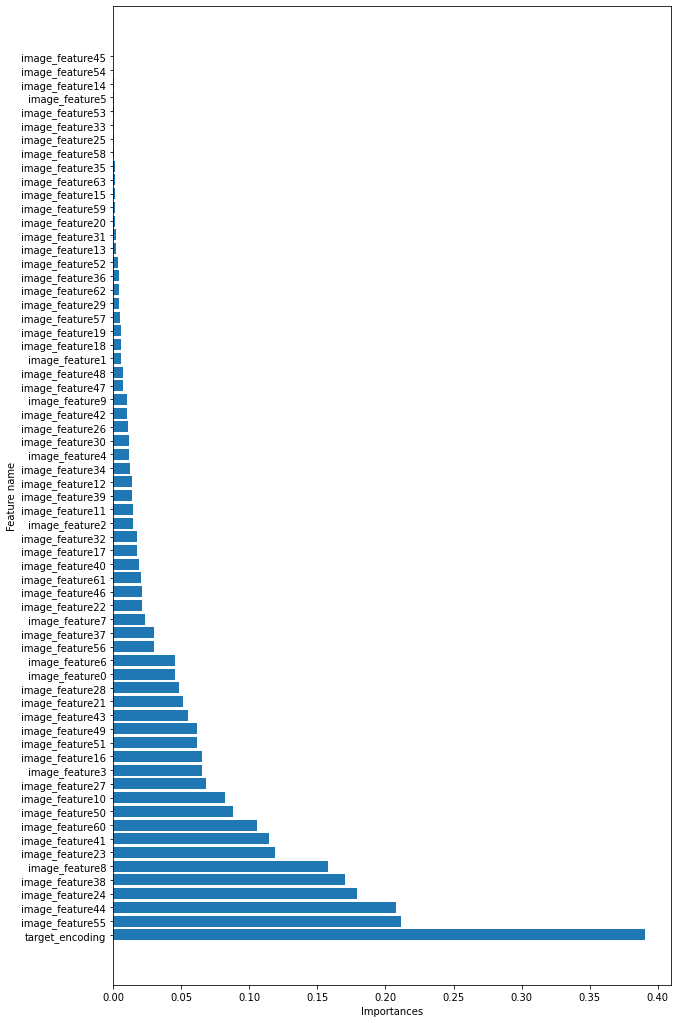

In [9]:
plot_importance(use_cols, abs(linear_model.coef_))

In [10]:
linear_model.coef_

array([ 4.56456601e-02,  6.04977877e-03,  1.44757922e-02,  6.51699309e-02,
       -1.16365503e-02, -6.16944587e-04, -4.55106392e-02,  2.31536596e-02,
        1.57410668e-01,  9.87561804e-03,  8.23193559e-02, -1.41774518e-02,
        1.39383660e-02, -2.33036205e-03, -2.58054104e-04,  1.33286084e-03,
        6.48915924e-02, -1.73899620e-02, -5.89031663e-03,  5.50736131e-03,
       -1.50344328e-03,  5.11035908e-02, -2.14396708e-02,  1.19154556e-01,
        1.79171824e-01,  8.85773460e-04, -1.11458414e-02,  6.79704116e-02,
        4.86905350e-02, -4.23250426e-03,  1.14378077e-02, -1.96170775e-03,
        1.73312276e-02, -8.50951783e-04, -1.26322080e-02, -9.63011191e-04,
       -3.90319574e-03, -2.97008214e-02,  1.70494312e-01,  1.40048155e-02,
        1.89521570e-02,  1.14173768e-01, -1.04025181e-02,  5.51532808e-02,
        2.07751964e-01, -4.37573900e-05,  2.13918917e-02, -7.16851921e-03,
       -7.00914270e-03,  6.16765676e-02,  8.79078375e-02, -6.17970399e-02,
       -3.81814238e-03, -

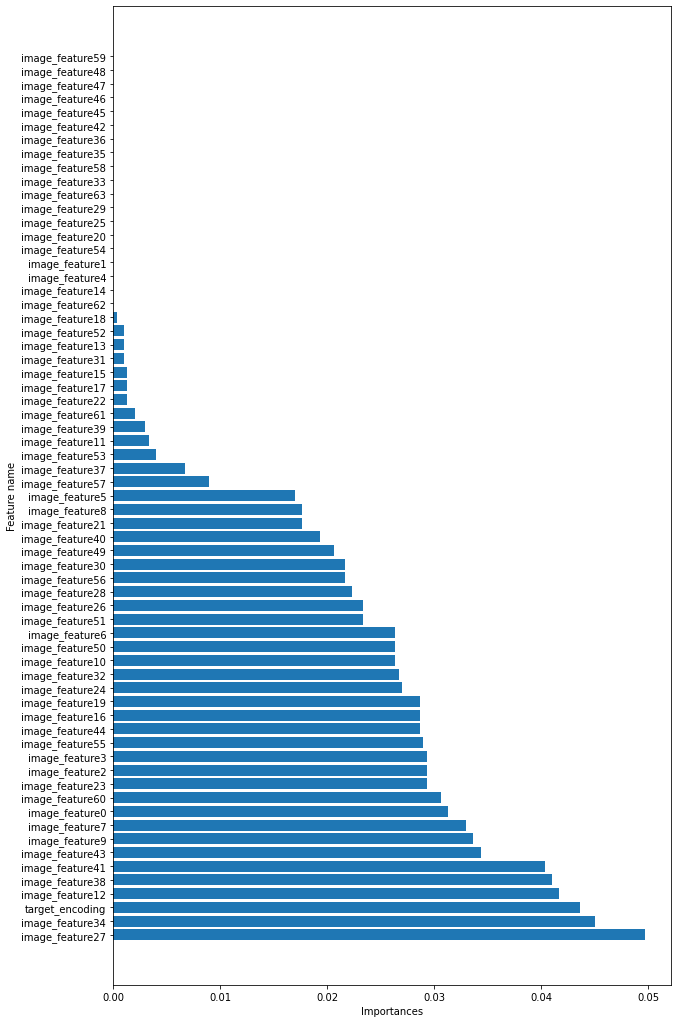

In [11]:
plot_importance(use_cols, lgb_model.feature_importances_/lgb_model.feature_importances_.sum())